In [168]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy
import math
import copy
import noise

In [341]:
# helper functions
def find_neighbours(arr):

    neighbors = []

    for i in range(len(arr)):
        for j, value in enumerate(arr[i]):

            if i == 0 or i == len(arr) - 1 or j == 0 or j == len(arr[i]) - 1:
                # corners
                new_neighbors = []
                if i != 0:
                    new_neighbors.append(arr[i - 1][j])  # top neighbor
                if j != len(arr[i]) - 1:
                    new_neighbors.append(arr[i][j + 1])  # right neighbor
                if i != len(arr) - 1:
                    new_neighbors.append(arr[i + 1][j])  # bottom neighbor
                if j != 0:
                    new_neighbors.append(arr[i][j - 1])  # left neighbor

            else:
                # add neighbors
                new_neighbors = [
                    arr[i - 1][j],  # top neighbor
                    arr[i][j + 1],  # right neighbor
                    arr[i + 1][j],  # bottom neighbor
                    arr[i][j - 1]   # left neighbor
                ]

            neighbors.append({
                value: new_neighbors
                })

    return neighbors


def neighbors_full(matrix,radius, row_number, column_number):
     return [[matrix[i][j] if  i >= 0 and i < len(matrix) and j >= 0 and j < len(matrix[0]) else 0
                for j in range(column_number-1-radius, column_number+radius)]
                    for i in range(row_number-1-radius, row_number+radius)]


def flatten(l):
    return [item for sublist in l for item in sublist]


def calculate_next_step(pheromones_l,pheromones_r):
    p_left = ((5+pheromones_l)**2)/((5+pheromones_l)**2+((5+pheromones_r)**2))
    p_right = 1 - p_left

    return p_left, p_right

def take_next_step(pheromones_l,pheromones_r):
    return 0.5 + 0.5*np.tanh((pheromones_l+pheromones_r)/100 -1)


def multiplot(nodes):
    food_dist = []
    pheromone_dist = []
    max_capa_dist = []
    capacity_dist = []


    for i in range(len(nodes)):
        food_dist.append(nodes[i].get_food())
        capacity_dist.append(nodes[i].get_capacity())
        max_capa_dist.append(nodes[i].get_max_capacity())
        pheromone_dist.append(nodes[i].get_pheromones())


    food_dist = np.array(food_dist).reshape(-1,int(np.sqrt(len(nodes))))
    capacity_dist = np.array(capacity_dist).reshape(-1,int(np.sqrt(len(nodes))))
    max_capa_dist = np.array(max_capa_dist).reshape(-1,int(np.sqrt(len(nodes))))
    pheromone_dist = np.array(pheromone_dist).reshape(-1,int(np.sqrt(len(nodes))))

    
    fig, axes = plt.subplots(2, 2,figsize=(20,16),dpi=100)
    sns.heatmap(capacity_dist,ax=axes[0,0],cmap="viridis",annot=False,vmax=10,xticklabels=False,yticklabels=False)
    axes[0,0].set_title('Capacity')
    sns.heatmap(pheromone_dist,ax=axes[0,1],cmap="viridis",annot=False,vmax=100,xticklabels=False,yticklabels=False)
    axes[0,1].set_title('Pheromones')
    sns.heatmap(max_capa_dist,ax=axes[1,0],cmap="terrain",annot=False,vmax=20,xticklabels=False,yticklabels=False)
    axes[1,0].set_title('maximum capacity')
    sns.heatmap(food_dist,ax=axes[1,1],cmap="viridis",annot=False,vmax=10,xticklabels=False,yticklabels=False)
    axes[1,1].set_title('Food')



In [186]:
# nodes class and ant class
class CreateNodes:
    def __init__(self, food=0, pheromones=0,x_coord=0, y_coord=0,evaporation_rate=1):
        self._food = food
        self._pheromones = pheromones
        self._max_pheromones = 100
        self._evaporation_rate = evaporation_rate
        self._capacity = 0
        self._max_capacity = 25
        self._x_coordinates = x_coord
        self._y_coordinates = y_coord
        self._connected_nodes = None
        self._connected_nodes_backwards = None
        self._connected_nodes_forwards = None
        self._node_number = None

    def create_label(self,label):
        self._node_number = label

    def update_food(self, food):
        self._food = food 
        
    def increase_food(self):
        self._food += 1

    def decrease_food(self):
        self._food -= 1

    def update_pheromones(self, dropped_pheromones):
        self._pheromones = self._pheromones + dropped_pheromones

    def reset_pheromones(self):
        self._pheromones = 0

    def evaporation(self):
        self._pheromones = self._pheromones - self._pheromones * self._evaporation_rate

    def set_capacity(self):
        self._capacity = 10

    def update_capacity(self, new_capacity):
        self._capacity = self._capacity + new_capacity

    def increase_capacity(self):
        self._capacity = self._capacity + 1

    def reduce_capacity(self):
        self._capacity = self._capacity - 1

    def update_max_capacity(self, max_capacity):
        self._max_capacity = max_capacity

    def update_x_coordinates(self, x_coord):
        self._x_coordinates = x_coord

    def update_y_coordinates(self, y_coord):
        self._y_coordinates = y_coord

    def update_connected_nodes(self, connected_nodes):
        self._connected_nodes = connected_nodes

    def update_connected_nodes_backwards(self):
        self._connected_nodes_backwards = [node for node in self._connected_nodes if node < self._node_number]

    def update_connected_nodes_forwards(self):
        self._connected_nodes_forwards = [node for node in self._connected_nodes if node > self._node_number]

    def get_label(self):
        return self._node_number

    def get_food(self):
        return self._food

    def get_pheromones(self):
        return self._pheromones

    def get_capacity(self):
        return self._capacity

    def get_x_coordinates(self):
        return self._x_coordinates

    def get_y_coordinates(self):
        return self._y_coordinates

    def get_node_number(self):
        return self._node_number

    def get_connected_nodes(self):
        return self._connected_nodes

    def get_connected_nodes_backwards(self):
        return self._connected_nodes_backwards
    
    def get_connected_nodes_forwards(self):
        return self._connected_nodes_forwards

    def get_max_capacity(self):
        return self._max_capacity



class Ants:
    def __init__(self):
        self._food = 0
        self._location = None
        self._ant_number = None

    def food_level(self):
        return self._food

    def pick_up_food(self, food):
        self._food = food
    
    def drop_food(self):
        self._food = 0
        
    def check_pheromones(self, pheromones):
        pass

    def update_ant_number(self, ant_number):
        self._ant_number = ant_number

    def get_ant_number(self):
        return self._ant_number

    def update_location(self,location):
        self._location = location
    
    def get_location(self):
        return self._location

In [337]:
# create nodes for the experiment
def create_nodes(n,evaporation_rate,randomise_capacity=False,m=1,terrain=False,one_tree = False,realistic_world=True):
    nodes = {}


    population = [0,1,2,10] # w/ 0,0 there is no food
    weights = [0.5,0.3,0.1,0.01]

    ys = []

    for i in range(0,int(math.sqrt(n))):
        for j in range(0,int(math.sqrt(n))):
            ys.append(j)

    ys = sorted(ys)

    
    nodes = {}
    node_labels = list(range(n))

    for i in range(n):
        if i < n/m:
            food = 0
        else:
            food = random.choices(population, weights=weights)[0]
        nodes[i] = CreateNodes(food=food,x_coord=i,evaporation_rate=evaporation_rate)
        nodes[i].create_label(i)

    for idx, j in enumerate(ys):
        nodes[node_labels[idx]].update_y_coordinates(j)

    node_array = np.array(node_labels).reshape(-1,int(math.sqrt(n)))
    neigbors_dict = find_neighbours(node_array)

    for i in range(n):
        nodes[i].update_connected_nodes(neigbors_dict[i][i])
        nodes[i].update_connected_nodes_backwards()
        nodes[i].update_connected_nodes_forwards()


    if randomise_capacity:
        for i in range(n):
            nodes[i].update_max_capacity(random.randint(5,20))

    if terrain:
        A = np.arange(n).reshape(-1,int(np.sqrt(n)))
        all_nodes = A.flatten().tolist()

    
        for i in range(20):
            tree = random.choice(all_nodes)
            tree_index = np.where(A==tree)
            tree_values = flatten(neighbors_full(A,random.randint(2,7),int(tree_index[0]),int(tree_index[1])))

            for node in range(len(nodes)):
                if nodes[node].get_node_number() in tree_values:
                    nodes[node].update_max_capacity(0)


    if one_tree:
        A = np.arange(n).reshape(-1,int(np.sqrt(n)))
        # tree = A[int(np.sqrt(n)/3),int(np.sqrt(n)/2)]
        tree = A[30,35]
        tree2 = A[35,75]
        tree3 = A[65,50]

        tree_list = [tree, tree2, tree3]
        tree_nodes = []

        

        for tree in tree_list:
            tree_index = np.where(A==tree)
            tree_nodes.append(flatten(neighbors_full(A,random.randint(6,8),int(tree_index[0]),int(tree_index[1]))))

        tree_nodes = flatten(tree_nodes)

        for node in range(len(nodes)):
                if nodes[node].get_node_number() in tree_nodes:
                    nodes[node].update_max_capacity(-10)
                    nodes[node].update_food(-10)
                    # nodes[nodes].update_pheromones(-10)


    if realistic_world:
        shape = (100,100)
        scale = 120.0
        octaves = 60
        persistence = 0.5
        lacunarity = 2

        world = np.zeros(shape)
        for i in range(shape[0]):
            for j in range(shape[1]):
                world[i][j] = noise.pnoise2(i/scale, 
                                            j/scale, 
                                            octaves=octaves, 
                                            persistence=persistence, 
                                            lacunarity=lacunarity, 
                                            repeatx=1024, 
                                            repeaty=1024, 
                                            base=20) # 42 good, 12 linear, # 33 good

        world = np.interp(world, (world.min(), world.max()), (0,20))
        
        counter = 0
        for i in range(shape[0]):
            for j in range(shape[0]):
                nodes[counter].update_max_capacity(world[i,j])
                counter += 1


    return nodes, node_array

In [267]:
def model(nodes,steps,ants_per_step,max_ants):
    ants = []
    no_ants = len(ants)

    A = np.arange(len(nodes)).reshape(int(np.sqrt(len(nodes))),-1)
    start_node =  A[5,5] # this has to be automated
    nest_nodes = A[0:10,0:10].flatten().tolist()
    no_food_zone = A[0:15,0:15].flatten().tolist()

    for i in no_food_zone:
        nodes[i].update_food(0)
        nodes[i].update_max_capacity(20)

    nodes[start_node].update_max_capacity(10000)
    counter = 0

    for step in range(steps):
        for node in nodes: # evaporates some of the pheromones each step
            nodes[node].evaporation()
            pass
            

        if len(ants) < max_ants: # adding new ants until limit is reached at every step
            for i in range(ants_per_step): 
                test_ant = Ants()
                test_ant.update_ant_number(counter)
                test_ant.update_location(start_node)
                ants.append(test_ant)
                nodes[start_node].increase_capacity()
                counter += 1


        for i in range(len(ants)):
            location = ants[i].get_location()
        
            # has no food
            if ants[i].food_level() == 0:
                next_nodes = nodes[location].get_connected_nodes_forwards()

                pheromones_l = nodes[next_nodes[0]].get_pheromones()
                try:
                    pheromones_r = nodes[next_nodes[1]].get_pheromones()
                except:
                    ants[i].drop_food()
                    current_location = ants[i].get_location()
                    nodes[current_location].update_capacity(0)
                    ants[i].update_location(start_node)

                    continue
                
                probability_l, probability_r = calculate_next_step(pheromones_l,pheromones_r)

                if step < 10:
                    next_step_prob = 1
                else:
                    next_step_prob = take_next_step(pheromones_l,pheromones_r)



                if random.random() < next_step_prob:
                    if random.random() <= probability_l:
                        if nodes[next_nodes[0]].get_capacity() < nodes[next_nodes[0]].get_max_capacity():
                            
                            nodes[location].reduce_capacity()
                            ants[i].update_location(next_nodes[0]) # update ants location

                            if nodes[next_nodes[0]].get_pheromones() >= 100:
                                pass
                            else:
                                nodes[next_nodes[0]].update_pheromones(1) # update next nodes pheromoes

                            nodes[next_nodes[0]].update_capacity(1) # update next nodes capacity
                            if nodes[next_nodes[0]].get_food() != 0:
                                ants[i].pick_up_food(1) # pick up food 
                                nodes[next_nodes[0]].decrease_food() # remove food from next node



                        elif nodes[next_nodes[1]].get_capacity() < nodes[next_nodes[1]].get_max_capacity():
                            
                            nodes[location].reduce_capacity()
                            ants[i].update_location(next_nodes[1]) # update ants location
                            
                            if nodes[next_nodes[1]].get_pheromones() >= 100: # update pheromones
                                pass
                            else:
                                nodes[next_nodes[1]].update_pheromones(1)

                            nodes[next_nodes[1]].update_capacity(1)

                            if nodes[next_nodes[1]].get_food()!= 0:
                                ants[i].pick_up_food(1)
                                nodes[next_nodes[1]].decrease_food()


                        else:
                            continue


                    elif random.random() > probability_l:
                        if nodes[next_nodes[1]].get_capacity() < nodes[next_nodes[1]].get_max_capacity():

                            nodes[location].reduce_capacity()
                            ants[i].update_location(next_nodes[1])

                            if nodes[next_nodes[1]].get_pheromones() >= 100:
                                pass
                            else:
                                nodes[next_nodes[1]].update_pheromones(1)

                            nodes[next_nodes[1]].update_capacity(1)
                        
                            if nodes[next_nodes[1]].get_food()!= 0:
                                ants[i].pick_up_food(1)
                                nodes[next_nodes[1]].decrease_food()





                        elif nodes[next_nodes[0]].get_capacity() < nodes[next_nodes[0]].get_max_capacity():
                            
                            nodes[location].reduce_capacity()
                            ants[i].update_location(next_nodes[0]) # update ants location

                            if nodes[next_nodes[0]].get_pheromones() >= 100:
                                pass
                            else:
                                nodes[next_nodes[0]].update_pheromones(1) # update next nodes pheromoes

                            nodes[next_nodes[0]].update_capacity(1) # update next nodes capacity
                            if nodes[next_nodes[0]].get_food() != 0:
                                ants[i].pick_up_food(1) # pick up food 
                                nodes[next_nodes[0]].decrease_food()


                    else:
                        continue

                else:
                    continue


            # ant has food 
            elif ants[i].food_level() == 1:
                next_nodes = nodes[location].get_connected_nodes_backwards()
                
                pheromones_l = nodes[next_nodes[0]].get_pheromones()
                try:
                    pheromones_r = nodes[next_nodes[1]].get_pheromones()
                except:
                    ants[i].drop_food()
                    current_location = ants[i].get_location()
                    nodes[current_location].update_capacity(0)
                    ants[i].update_location(start_node)
                    continue

                

                probability_l, probability_r = calculate_next_step(pheromones_l,pheromones_r)

                if probability_l == probability_r:
                    # print(ants[i].get_ant_number(), 'WARNING! STRAY ANT')
                    ants[i].drop_food()
                    current_location = ants[i].get_location()
                    nodes[current_location].update_capacity(0)
                    nodes[current_location].reset_pheromones()
                    ants[i].update_location(start_node)

                if ants[i].get_location() < start_node:
                    ants[i].drop_food()
                    current_location = ants[i].get_location()
                    nodes[current_location].update_capacity(0)
                    # nodes[current_location].reset_pheromones()
                    ants[i].update_location(start_node)



                next_step_prob = take_next_step(pheromones_l,pheromones_r)

                if random.random() < next_step_prob:
                    if random.random() <= probability_l:
                        if nodes[next_nodes[0]].get_capacity() < nodes[next_nodes[0]].get_max_capacity():
                            
                            nodes[location].reduce_capacity()
                            ants[i].update_location(next_nodes[0]) # update ants location

                            if next_nodes[0] in nest_nodes:
                                ants[i].drop_food()
                                nodes[start_node].increase_food()


                            if nodes[next_nodes[0]].get_pheromones() >= 100:
                                pass
                            else:
                                nodes[next_nodes[0]].update_pheromones(10) # update next nodes pheromoes
                            nodes[next_nodes[0]].update_capacity(1) # update next nodes capacity


                        elif nodes[next_nodes[1]].get_capacity() < nodes[next_nodes[1]].get_max_capacity():
                            
                            nodes[location].reduce_capacity()
                            ants[i].update_location(next_nodes[1]) # update ants location


                            if next_nodes[1] in nest_nodes:
                                ants[i].drop_food()
                                nodes[start_node].increase_food()
                            
                            if nodes[next_nodes[1]].get_pheromones() >= 100: # update pheromones
                                pass
                            else:
                                nodes[next_nodes[1]].update_pheromones(10)

                            nodes[next_nodes[1]].update_capacity(1)

                        else:
                            continue


                    elif random.random() > probability_l:
                        if nodes[next_nodes[1]].get_capacity() < nodes[next_nodes[1]].get_max_capacity():

                            nodes[location].reduce_capacity()
                            ants[i].update_location(next_nodes[1])

                            if next_nodes[1] in nest_nodes:
                                ants[i].drop_food()
                                nodes[start_node].increase_food()

                            if nodes[next_nodes[1]].get_pheromones() >= 100:
                                pass
                            else:
                                nodes[next_nodes[1]].update_pheromones(10)

                            nodes[next_nodes[1]].update_capacity(1)
                        

                        elif nodes[next_nodes[0]].get_capacity() < nodes[next_nodes[0]].get_max_capacity():
                            
                            nodes[location].reduce_capacity()
                            ants[i].update_location(next_nodes[0]) # update ants location

                            if next_nodes[0] in nest_nodes:
                                ants[i].drop_food()
                                nodes[start_node].increase_food()

                            if nodes[next_nodes[0]].get_pheromones() >= 100:
                                pass
                            else:
                                nodes[next_nodes[0]].update_pheromones(10) # update next nodes pheromoes

                            nodes[next_nodes[0]].update_capacity(1) # update next nodes capacity


                        else:
                            continue
                        
                    else:
                        continue

                else:
                    continue






            else:
                continue


    nodes[start_node].set_capacity()

    # Analytics
    returning_ants = 0
    exploring_ants = 0

    for i in range(len(ants)):
        if ants[i].food_level() == 1:
            returning_ants += 1
        elif  ants[i].food_level() == 0:
            exploring_ants += 1
       
    print(f'Currently {exploring_ants} ants are searching for food and {returning_ants} ants transport food back to the nest. {nodes[start_node].get_food()} food items are in the nest.')




                





    return nodes

Currently 1507 ants are searching for food and 493 ants transport food back to the nest. 795 food items are in the nest.


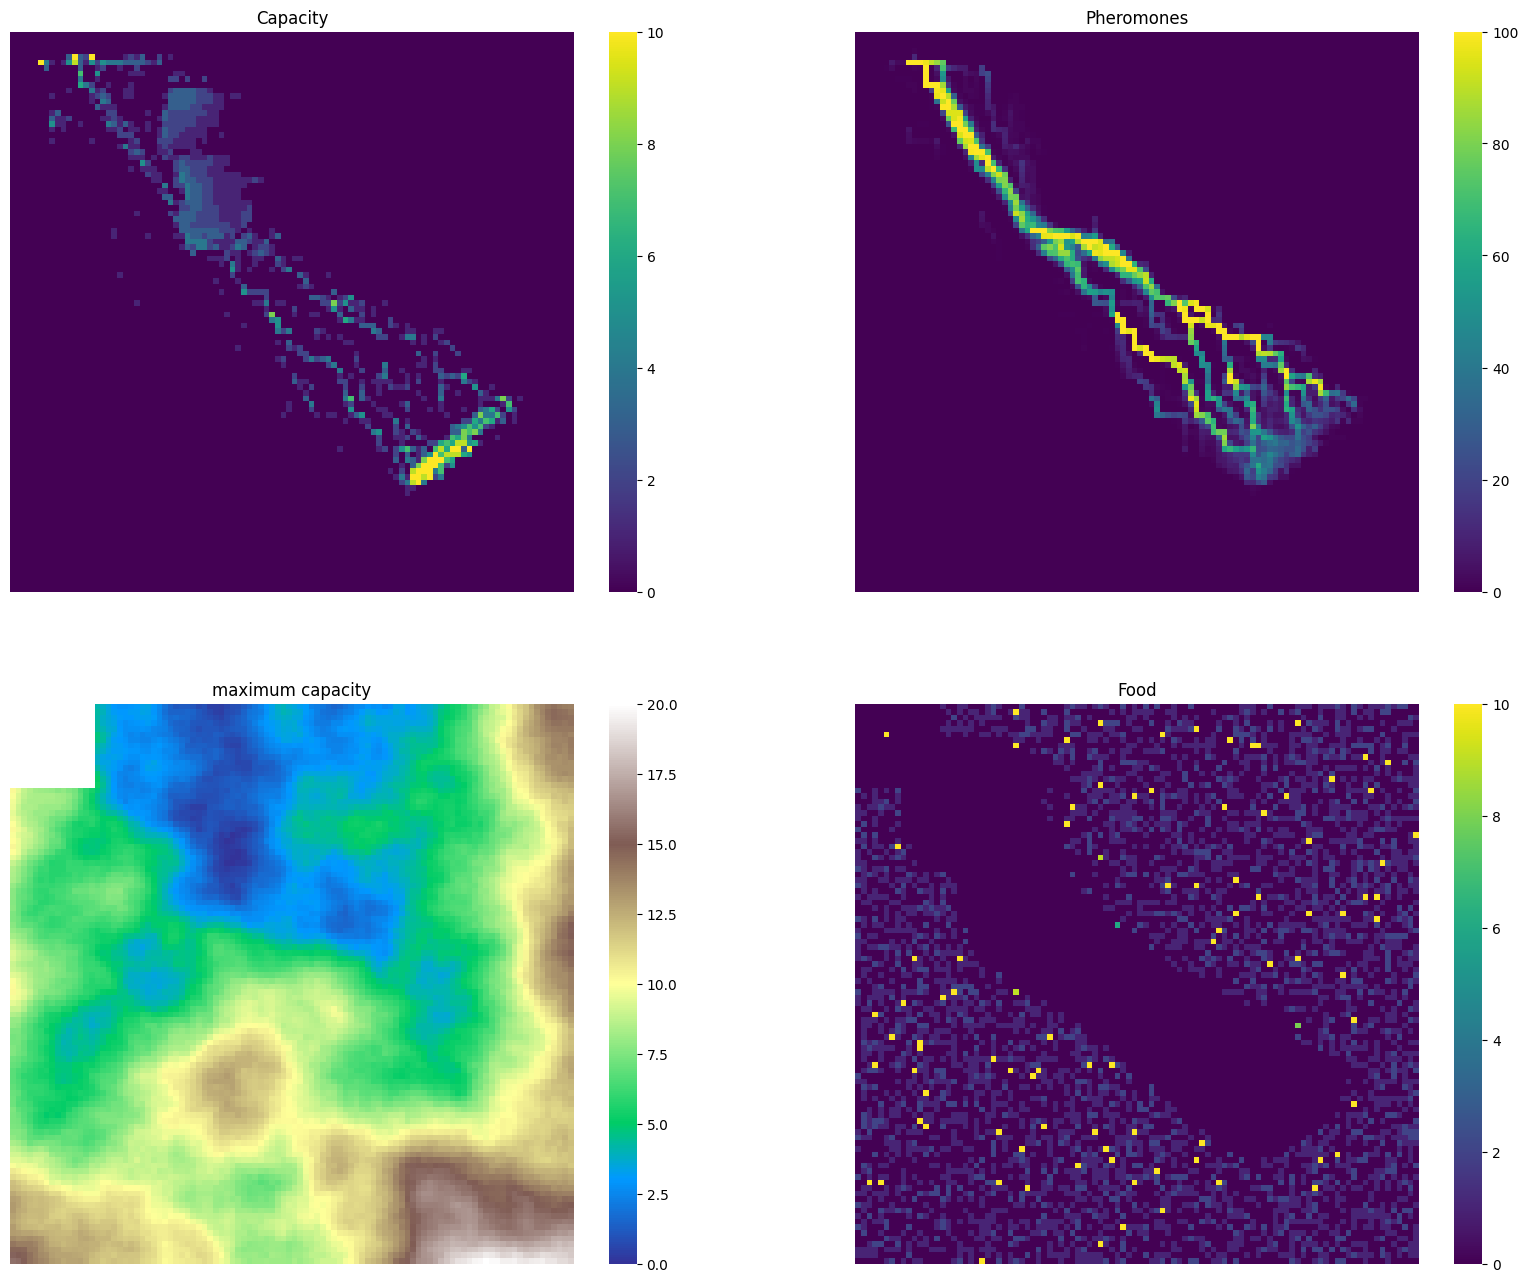

In [344]:
nodes, node_array = create_nodes(n=10000,m=10000,randomise_capacity = True,terrain=False, evaporation_rate=1/30)
# print(node_array[10,10])
# visualise_food(nodes)
new_nodes = model(nodes=nodes,steps=1250,ants_per_step=10,max_ants=2000)
multiplot(new_nodes)